In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import csv
import json
import sklearn
from google.cloud import bigquery as bq
import seaborn as sns
import matplotlib.pyplot as plt
import time
import pathlib

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.options.mode.chained_assignment = None
%matplotlib inline

In [2]:
# # explore gradient boosting number of trees effect on performance
# from numpy import mean
# from numpy import std
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, Normalizer, OneHotEncoder
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
 

In [3]:
# Set random seeds

sampling_seed = np.random.seed(13)
train_test_seed = np.random.seed(69)
cv_seed = np.random.seed(37)
model_seed = np.random.seed(73)
np.random.seed(42) # set default seed value

In [4]:
def get_df(bq_table_name, sample_frac=None):
    query="""
    SELECT
      *
    FROM
      `ual3d-277909.nl.%s`
    """ % (bq_table_name)
    full_df = bq.Client().query(query).to_dataframe()
    if sample_frac:
        part_df = full_df.sample(frac=sample_frac, random_state=sampling_seed)
        return part_df
    return full_df

In [5]:
full_df = get_df("north_holland_ml_df")
full_df.head()

,osm_way_id,bldg_height,area,perimeter,length,building_levels,city,country,postcode,year,count_vertices,compactness,complexity,count_neighbor,state_name
0,278208223,15.93,70.102182,40.381461,14.927666,NaN,None,NL,None,1913.0,9,0.735002,13.955620,707.0,North Holland
1,266008678,8.75,48.732054,29.191859,10.597522,NaN,None,NL,None,1936.0,9,0.847716,11.048621,1525.0,North Holland
2,285234908,2.46,25.628454,22.138255,7.858663,NaN,None,NL,None,1948.0,7,0.810630,9.839268,1354.0,North Holland
3,266008456,10.15,57.666084,31.778958,11.701340,NaN,None,NL,None,1936.0,9,0.847082,11.532130,1064.0,North Holland
4,284151169,2.46,10.402227,12.939155,4.594016,NaN,None,NL,None,1911.0,6,0.883613,7.204840,1079.0,North Holland


In [7]:
df_10prct = full_df.sample(frac=0.1, random_state=sampling_seed)
df_10prct.head()

,osm_way_id,bldg_height,area,perimeter,length,building_levels,city,country,postcode,year,count_vertices,compactness,complexity,count_neighbor,state_name
764897,267972641,2.59,5.010139,8.979988,3.185951,NaN,None,NL,None,1978.0,5,0.883597,6.002240,279.0,North Holland
212788,287102149,6.96,42.413134,30.991135,11.406776,NaN,None,NL,None,1927.0,10,0.744934,12.144018,299.0,North Holland
1070353,283571181,9.10,47.863660,30.229891,11.329440,NaN,None,NL,None,1996.0,7,0.811281,11.493045,808.0,North Holland
470115,265850879,2.38,8.186882,11.791489,4.290811,NaN,None,NL,None,1962.0,5,0.860192,6.970903,777.0,North Holland
200766,276836247,15.11,65.069771,33.044190,11.955497,NaN,None,NL,None,1926.0,5,0.865365,11.634569,567.0,North Holland


In [157]:
df_10prct.set_index('osm_way_id', inplace=True)

df_10prct["city"] = df_10prct["city"].astype("category")
df_10prct["postcode"] = df_10prct["postcode"].astype("category")
df_10prct["country"] = df_10prct["country"].astype("category")
df_10prct["state_name"] = df_10prct["state_name"].astype("category")

df_10prct.dtypes

bldg_height         float64
area                float64
perimeter           float64
length              float64
building_levels     float64
city               category
country            category
postcode           category
year                float64
count_vertices        int64
compactness         float64
complexity          float64
count_neighbor      float64
state_name         category
dtype: object

In [158]:
df_10prct.shape

(163867, 14)

In [159]:
df_10prct.isna().sum()


bldg_height             0
area                    0
perimeter               0
length                  0
building_levels    161552
city               163771
country                 0
postcode           163779
year                    9
count_vertices          0
compactness             0
complexity              0
count_neighbor         22
state_name              0
dtype: int64

In [160]:
print('unique city:', pd.unique(df_10prct['city']))
print('unique postcode:', pd.unique(df_10prct['postcode']))

unique city: [NaN, Rotterdam, Barendrecht, Nootdorp, Zoetermeer, ..., Katwijk, Oud-Beijerland, Voorschoten, Driebruggen, Maasdijk]
Length: 36
Categories (35, object): [Rotterdam, Barendrecht, Nootdorp, Zoetermeer, ..., Oud-Beijerland, Voorschoten, Driebruggen, Maasdijk]
unique postcode: [NaN, 3015AA, 2991XV, 2631CD, 2595BT, ..., 2641DL, 2514AP, 2676CT, 3131HC, 2517ER]
Length: 84
Categories (83, object): [3015AA, 2991XV, 2631CD, 2595BT, ..., 2514AP, 2676CT, 3131HC, 2517ER]


In [161]:
label_col = ["bldg_height"]
# num_cols = ["area", "perimeter", "length", "building_levels", "year", "count_vertices", "compactness", "complexity", "count_neighbor"]
num_cols = ["area", "perimeter", "length", "building_levels", "year", "count_vertices", "compactness", "complexity", "count_neighbor"]
cat_cols = ["city", "postcode"]
# cat_cols = [col for col in df.columns if col not in (num_cols + label_col)]

In [162]:
cat_df = df_10prct[cat_cols]
num_df = df_10prct[num_cols]

In [163]:
num_df.describe()

,area,perimeter,length,building_levels,year,count_vertices,compactness,complexity,count_neighbor
count,163867.000000,163867.000000,163867.000000,2315.000000,163858.000000,163867.000000,163867.000000,163867.000000,163845.000000
mean,127.041194,34.397230,12.488691,1.562419,1970.099965,7.305400,0.820480,11.502573,627.181336
std,1130.536369,41.722332,14.712017,1.704604,36.840243,5.006298,0.069789,5.091311,308.019580
min,0.011879,2.515305,1.126222,-2.000000,1337.000000,4.000000,0.047037,3.565088,1.000000
25%,11.037920,13.797679,5.038909,1.000000,1957.000000,5.000000,0.791686,7.565395,430.000000
50%,50.104437,29.782798,10.862555,1.000000,1976.000000,5.000000,0.843835,11.139180,640.000000
75%,71.789144,38.936174,14.341103,2.000000,1993.000000,8.000000,0.872025,13.345677,833.000000
max,99107.311961,2229.810651,553.170701,43.000000,2020.000000,270.000000,0.999942,126.630204,2119.000000


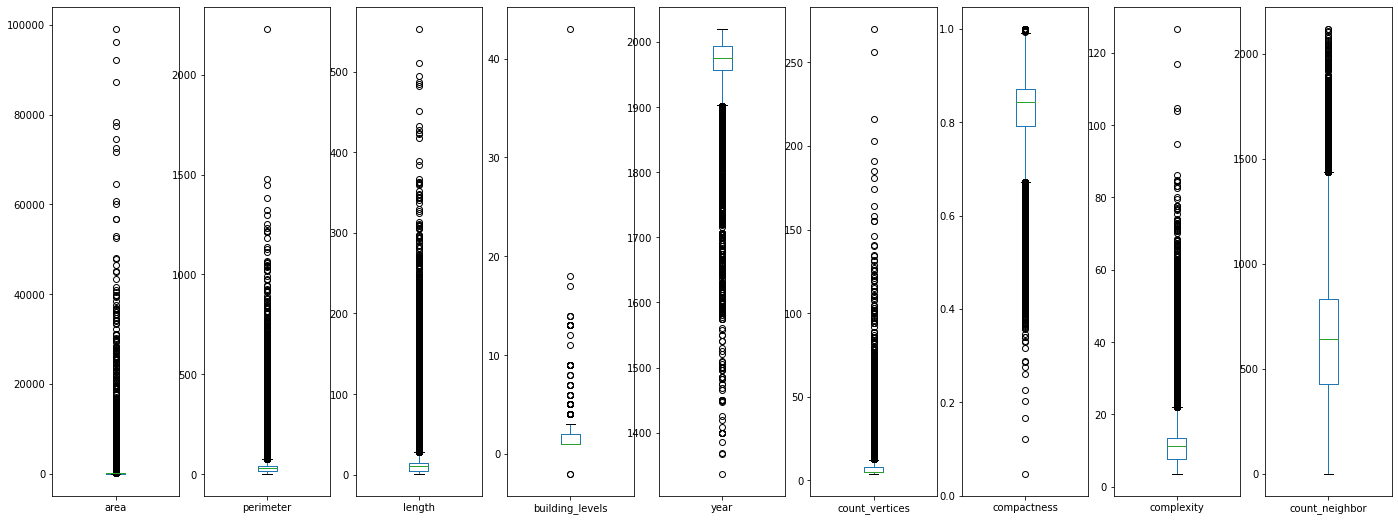

In [164]:
num_df.plot(kind='box', subplots=True, figsize=(24,9))
plt.plot()
plt.savefig('gradientboost_10prct/run0/exploratory/south_holland_basic_distribution_null.png')

In [165]:
X = df_10prct.drop('bldg_height', axis=1).drop(['country', 'state_name'], axis=1).drop(['perimeter'], axis=1)
y = df_10prct['bldg_height']


In [166]:

X, y

(                   area      length  building_levels city postcode    year  \
 osm_way_id                                                                   
 274861575     10.974721    4.777413              NaN  NaN      NaN  1975.0   
 290156453      9.108948    4.791012              NaN  NaN      NaN  1970.0   
 273619615    131.187203   18.782197              NaN  NaN      NaN  1992.0   
 298660513   5331.990905  132.276419              NaN  NaN      NaN  1978.0   
 273614366      6.159092    3.647240              NaN  NaN      NaN  2008.0   
 ...                 ...         ...              ...  ...      ...     ...   
 290658292     46.834448   10.772048              NaN  NaN      NaN  1981.0   
 267276893     63.744637   11.797846              NaN  NaN      NaN  2010.0   
 274076889     53.037771   13.270984              NaN  NaN      NaN  1920.0   
 273868434     15.103665    5.884999              NaN  NaN      NaN  1723.0   
 273832692      7.937854    4.248007              Na

In [167]:
mean_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean', add_indicator=True)),
    ('scaler', StandardScaler())])

freq_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=1, add_indicator=True)),
    ('scaler', StandardScaler())])

zero_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0, add_indicator=True)),
    ('scaler', StandardScaler())])

In [168]:
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='NA', add_indicator=True)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [169]:
preprocessor = ColumnTransformer(transformers=[
        ('mean_transformer', mean_transformer, ["year"]),
        ('freq_transformer', freq_transformer, ["building_levels"]),
        ('zero_transformer', zero_transformer, ["count_neighbor"]),
        ('cat_transfomer', cat_transformer, cat_cols)])

In [179]:
# evaluate a given model using cross-validation
def evaluate_model(model):
    cv = ShuffleSplit(n_splits=10, test_size=.2, random_state=cv_seed)
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])
    mae_scores = cross_val_score(pipeline, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
    mse_scores = cross_val_score(pipeline, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
    r2_scores = cross_val_score(pipeline, X, y, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')
    return mae_scores, {}, {}

In [180]:
def loop_evaluate_models(param_name, models):
    for name, model in models.items():
        print('%s %s' % (param_name, name))
        tic = time.process_time()
        mae_scores, mse_scores, r2_scores = evaluate_model(model)
        toc = time.process_time()
        elapsed_time = toc - tic
        mae_reg_scores[name] = mae_scores
        print('MAE %.3f (%.3f) | Elapsed time %.3f seconds' % (np.mean(mae_scores), np.std(mae_scores), elapsed_time))
#         mse_reg_scores[name] = mse_scores
#         r2_reg_scores[name] = r2_scores
#         print('MAE %.3f (%.3f) | MSE %.3f (%.3f) | R2 %.3f (%.3f) | Elapsed time %.3f seconds' % (np.mean(mae_scores), np.std(mae_scores), np.mean(mse_scores), np.std(mse_scores), np.mean(r2_scores), np.std(r2_scores), elapsed_time))

In [181]:
def plot_param_plot(title, xlabel, ylabel, values, keys, filepath):
    fig = plt.figure(figsize=(16,9))
    fig.suptitle(title)
    ax = fig.add_subplot (111)
    
    plt.boxplot(values, showmeans=True)
    ax.set_xticklabels(keys)

    plt.tight_layout()
    plt.plot()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.savefig(filepath, dpi=600)

In [173]:
def convert_abs_scores(scores):
    abs_scores={}
    for k, v in scores.items():
        abs_scores[k] = np.absolute(v)
    return abs_scores

In [174]:
# get a list of models to evaluate

n_estimator_models = dict()
n_estimator_models['10'] = GradientBoostingRegressor(n_estimators=10, random_state=model_seed)
n_estimator_models['50'] = GradientBoostingRegressor(n_estimators=50, random_state=model_seed)
n_estimator_models['100'] = GradientBoostingRegressor(n_estimators=100, random_state=model_seed)
n_estimator_models['500'] = GradientBoostingRegressor(n_estimators=500, random_state=model_seed)
n_estimator_models['750'] = GradientBoostingRegressor(n_estimators=750, random_state=model_seed)
n_estimator_models['1000'] = GradientBoostingRegressor(n_estimators=1000, random_state=model_seed)
n_estimator_models['5000'] = GradientBoostingRegressor(n_estimators=5000, random_state=model_seed)
# n_estimator_models

In [175]:
mae_reg_scores, mse_reg_scores, r2_reg_scores = dict(), dict(), dict()

In [176]:
models = n_estimator_models
loop_evaluate_models('n_estimator', models)

n_estimator 10
MAE -2.969 (0.009) | MSE -13.256 (0.416) | R2 0.096 (0.003) | Elapsed time 3.583 seconds
n_estimator 50
MAE -2.875 (0.015) | MSE -12.448 (0.367) | R2 0.139 (0.009) | Elapsed time 3.026 seconds
n_estimator 100
MAE -2.853 (0.013) | MSE -12.443 (0.292) | R2 0.135 (0.004) | Elapsed time 3.091 seconds
n_estimator 500
MAE -2.839 (0.010) | MSE -12.506 (0.383) | R2 0.148 (0.007) | Elapsed time 3.059 seconds
n_estimator 750
MAE -2.843 (0.010) | MSE -12.329 (0.420) | R2 0.144 (0.010) | Elapsed time 3.109 seconds
n_estimator 1000
MAE -2.839 (0.011) | MSE -12.217 (0.306) | R2 0.145 (0.007) | Elapsed time 3.075 seconds
n_estimator 5000


KeyboardInterrupt: 

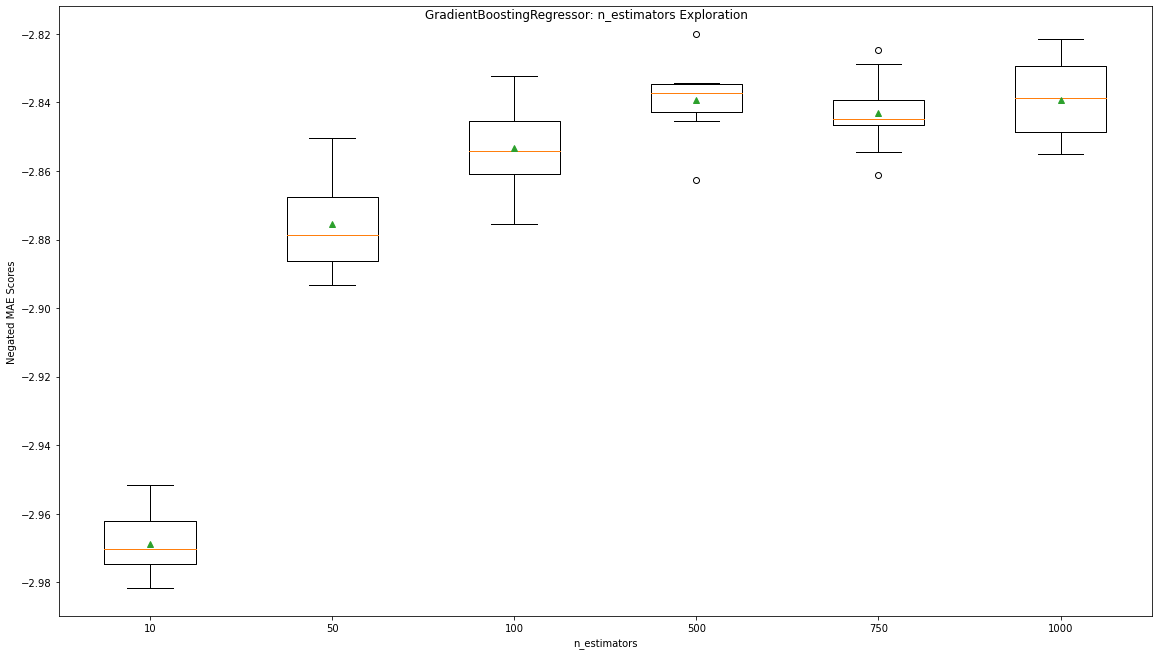

In [177]:
plot_param_plot('GradientBoostingRegressor: n_estimators Exploration', 'n_estimators', 'Negated MAE Scores', mae_reg_scores.values(), mae_reg_scores.keys(), 'gradientboost_10prct/run0/South-Holland_n_estimators_MAE.png')

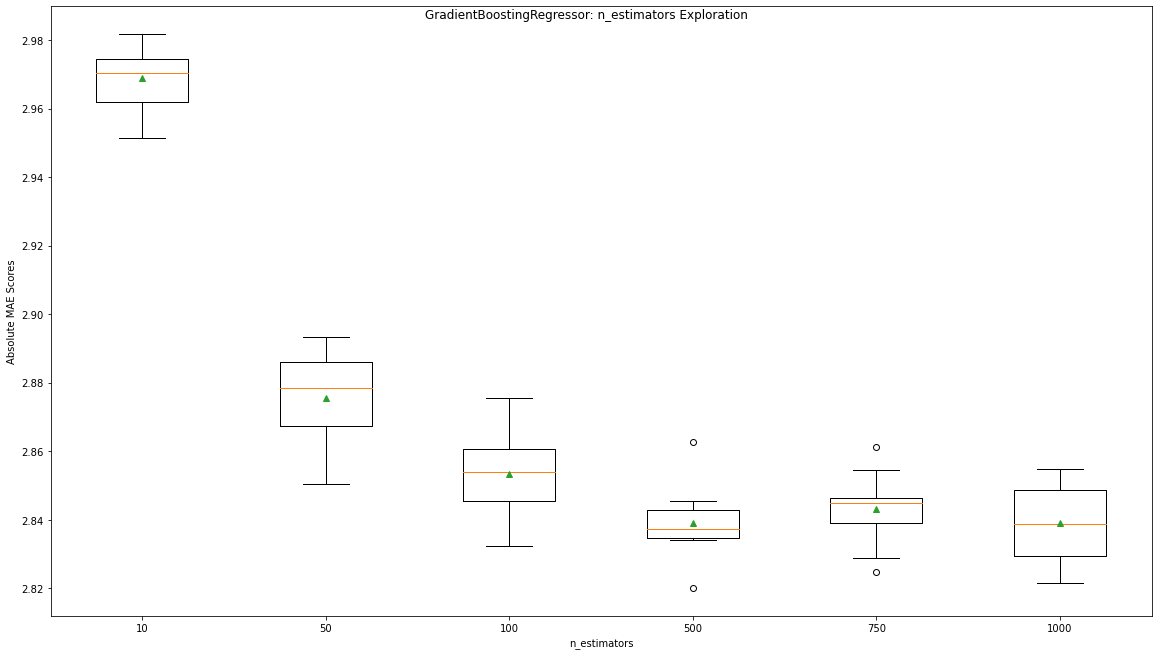

In [178]:
abs_mae_reg_scores = convert_abs_scores(mae_reg_scores)
plot_param_plot('GradientBoostingRegressor: n_estimators Exploration', 'n_estimators', 'Absolute MAE Scores', abs_mae_reg_scores.values(), abs_mae_reg_scores.keys(), 'gradientboost_10prct/run0/South-Holland_n_estimators_ABS-MAE.png')

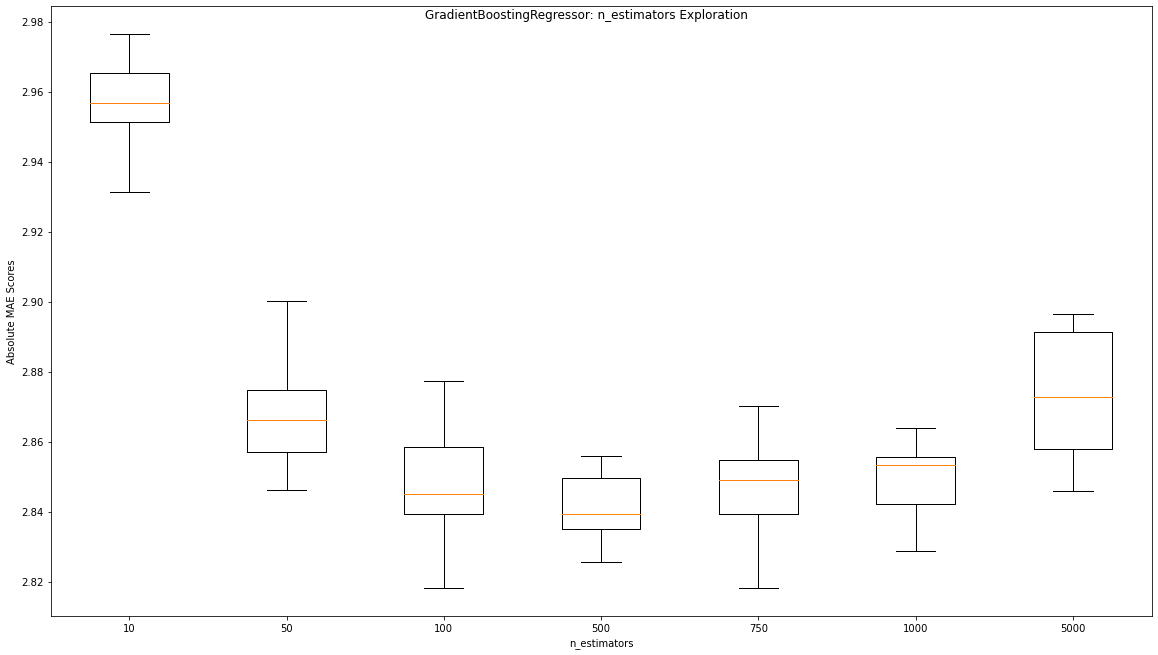

In [ ]:
plot_param_plot('GradientBoostingRegressor: n_estimators Exploration', 'n_estimators', 'Negated MSE Scores', mse_reg_scores.values(), mse_reg_scores.keys(), 'gradientboost_10prct/run0/South-Holland_n_estimators_MSE.png')

In [ ]:
abs_mse_reg_scores = convert_abs_scores(mse_reg_scores)
plot_param_plot('GradientBoostingRegressor: n_estimators Exploration', 'n_estimators', 'Absolute MSE Scores', abs_mse_reg_scores.values(), abs_mse_reg_scores.keys(), 'gradientboost_10prct/run0/South-Holland_n_estimators_ABS-MSE.png')

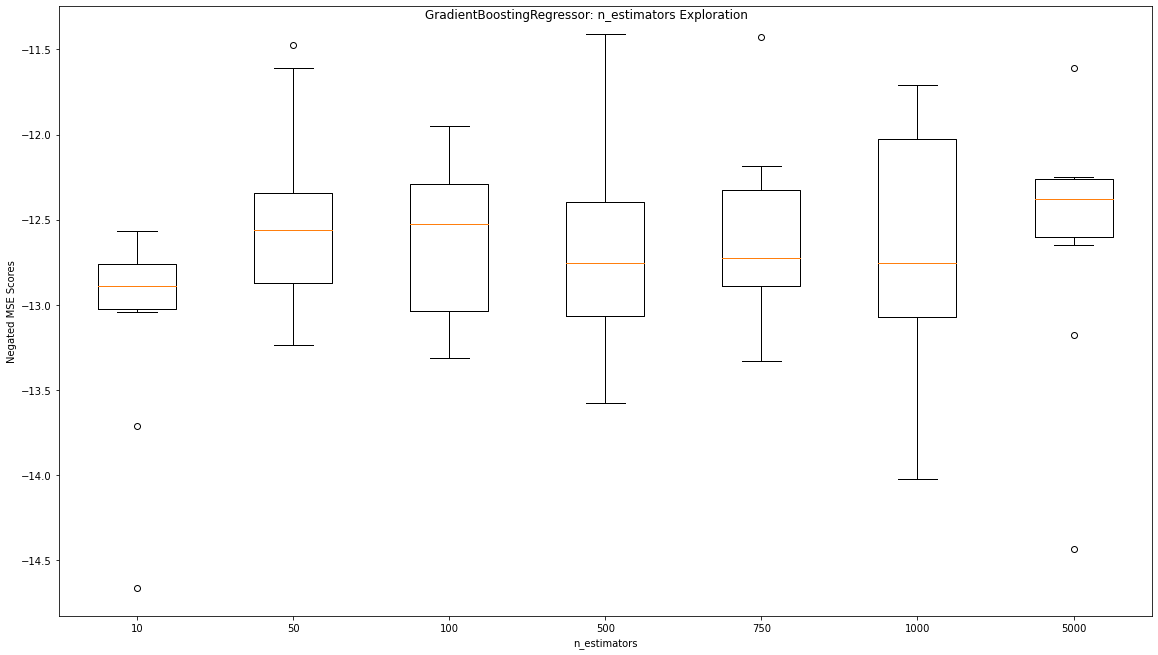

{'10': array([12.91799291, 14.66391679, 12.5676345 , 12.86176204, 12.73697688,
        12.77499562, 13.04261727, 12.96361929, 13.71089956, 12.75443686]),
 '50': array([12.89552835, 11.60649781, 11.47223076, 12.7908966 , 12.61213086,
        12.35555233, 12.50443232, 12.34040448, 13.23504464, 12.99668175]),
 '100': array([12.25450636, 12.32225497, 13.1332589 , 12.27839444, 13.04126236,
        13.3116481 , 13.02549459, 12.59390586, 11.94981928, 12.46075306]),
 '500': array([13.1115664 , 12.26431064, 12.93002123, 13.57930574, 12.76551382,
        12.33829958, 12.56528042, 13.17299984, 12.74773091, 11.41058903]),
 '750': array([12.84926158, 12.18202285, 12.58273435, 13.32805498, 12.8790694 ,
        12.89112404, 12.60079361, 12.24298655, 11.42878584, 13.02199547]),
 '1000': array([12.77574059, 11.70894872, 12.7278977 , 13.13603818, 13.15117379,
        12.87176624, 14.02140848, 11.94123822, 12.28000261, 11.90751545]),
 '5000': array([12.30584487, 12.29009552, 13.17780292, 12.46026447, 12.

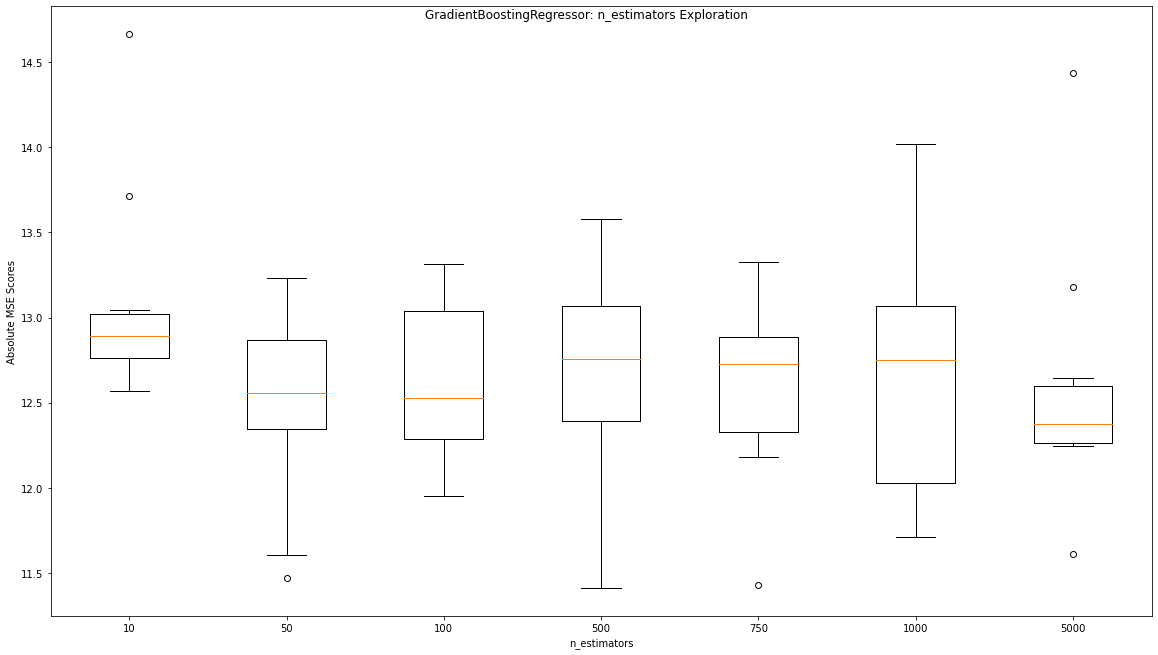

In [ ]:
plot_param_plot('GradientBoostingRegressor: n_estimators Exploration', 'n_estimators', 'R^2 Scores', r2_reg_scores.values(), r2_reg_scores.keys(), 'gradientboost_10prct/run0/South-Holland_n_estimators_R2.png')

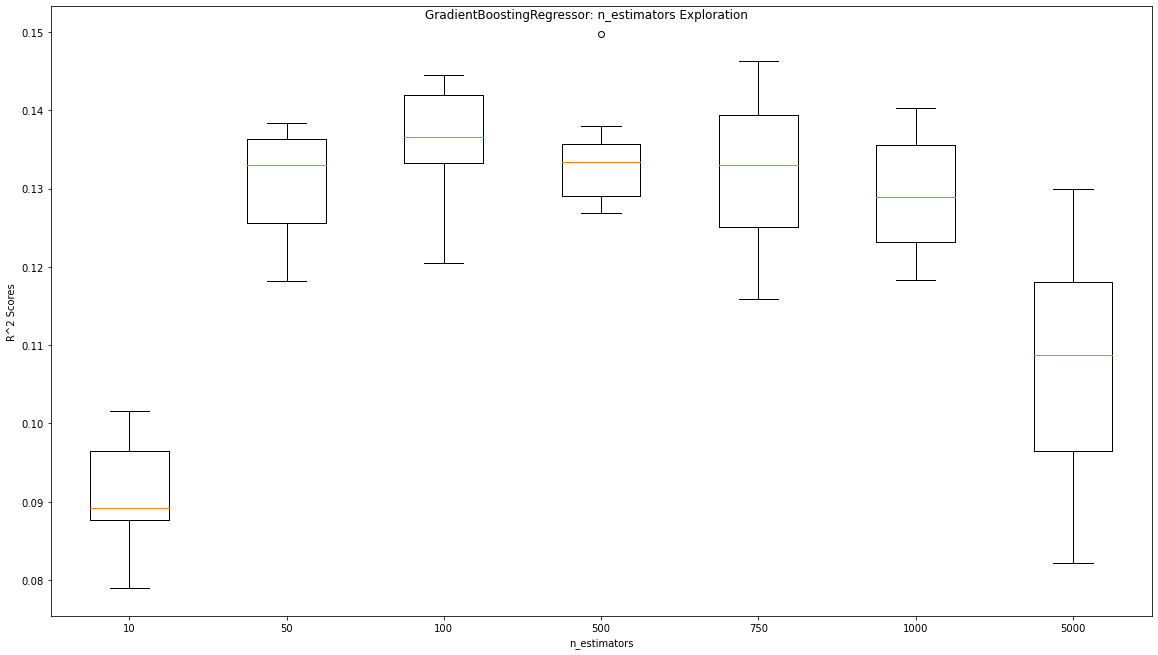

In [81]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('GradientBoostingRegressor: n_estimators Exploration')
ax = fig.add_subplot(111)

plt.boxplot(r2_reg_scores.values())
ax.set_xticklabels(r2_reg_scores.keys())


plt.tight_layout()
plt.plot()
plt.xlabel('n_estimators')
plt.ylabel('R^2 Scores')
plt.savefig('gradientboost_5prct/run0/South-Holland_n_estimators_R2.png', dpi=600)
plt.show()

In [182]:
lr_models = dict()
for i in [0.0001, 0.001, 0.01, 0.1, 1.0, 1.5]:
    key = '%.4f' % i
    lr_models[key] = GradientBoostingRegressor(learning_rate=i, random_state=model_seed)
# lr_models

In [183]:
mae_reg_scores, mse_reg_scores, r2_reg_scores = dict(), dict(), dict()

In [184]:
models = lr_models
loop_evaluate_models('learning_rate', models)

learning_rate 0.0001
MAE -3.109 (0.013) | Elapsed time 1.584 seconds
learning_rate 0.0010
MAE -3.089 (0.007) | Elapsed time 0.997 seconds
learning_rate 0.0100
MAE -2.967 (0.009) | Elapsed time 1.028 seconds
learning_rate 0.1000
MAE -2.854 (0.009) | Elapsed time 1.011 seconds
learning_rate 1.0000
MAE -2.847 (0.013) | Elapsed time 1.022 seconds
learning_rate 1.5000
MAE -2.859 (0.013) | Elapsed time 1.004 seconds


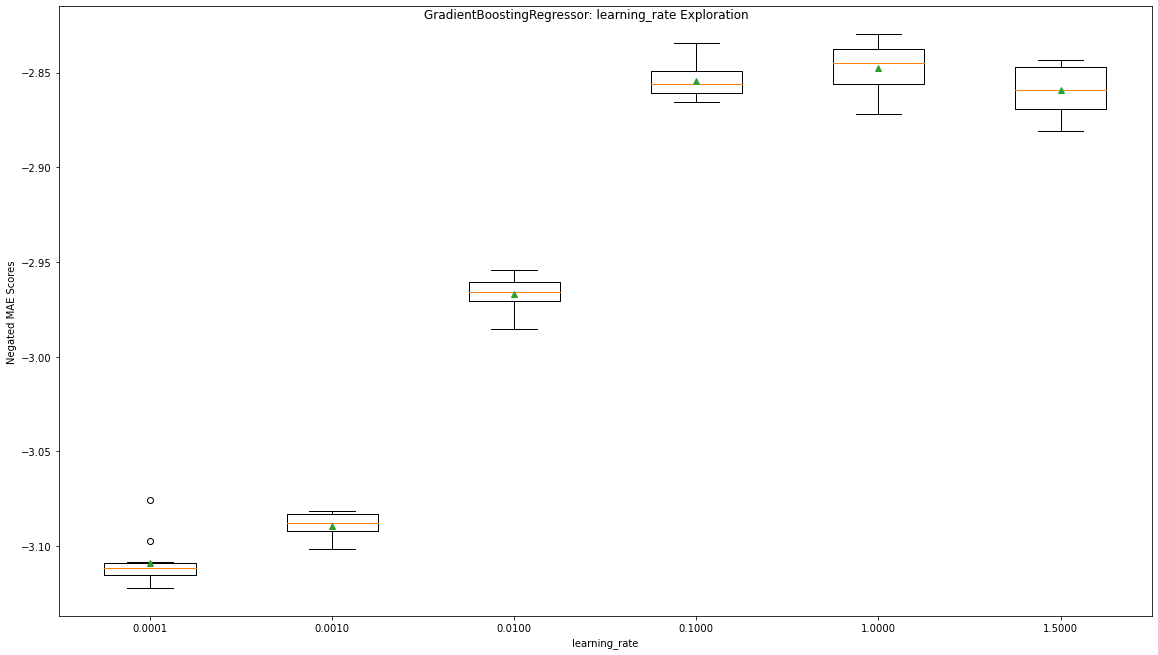

In [185]:
plot_param_plot('GradientBoostingRegressor: learning_rate Exploration', 'learning_rate', 'Negated MAE Scores', mae_reg_scores.values(), mae_reg_scores.keys(), 'gradientboost_10prct/run0/South-Holland_learning_rate_MAE.png')


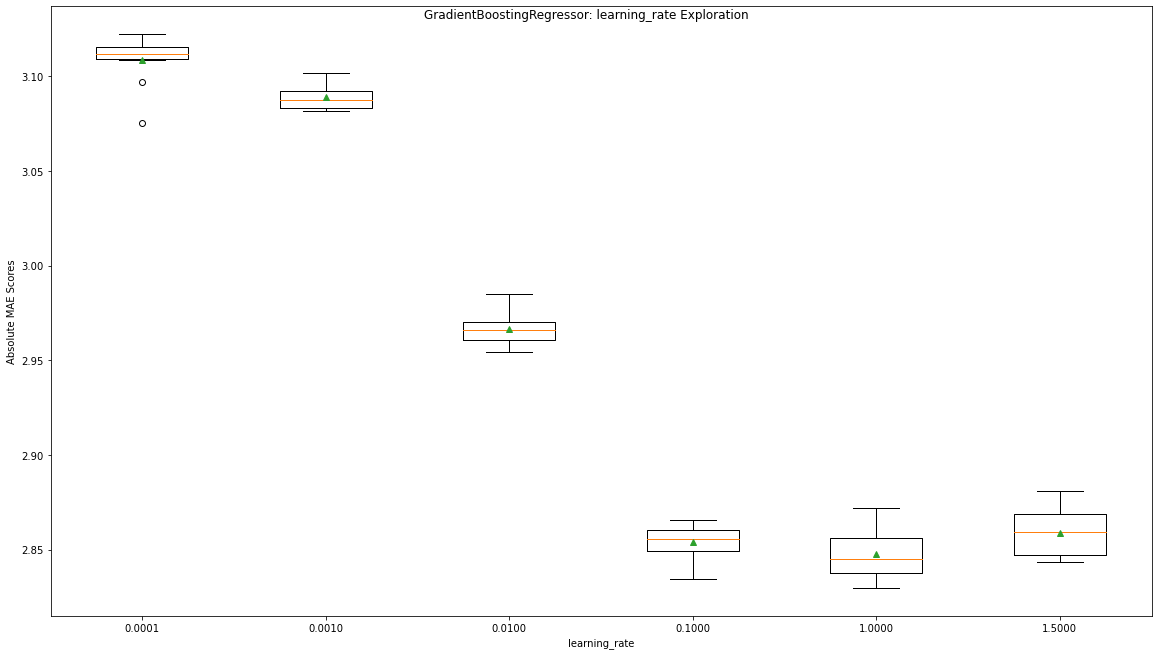

In [186]:
abs_mae_reg_scores = convert_abs_scores(mae_reg_scores)
plot_param_plot('GradientBoostingRegressor: learning_rate Exploration', 'learning_rate', 'Absolute MAE Scores', abs_mae_reg_scores.values(), abs_mae_reg_scores.keys(), 'gradientboost_10prct/run0/South-Holland_learning_rate_ABS-MAE.png')

In [187]:
subsample_models = dict()
for i in np.arange(0.1, 1.1, 0.1):
    key = '%.1f' % i
    subsample_models[str(i)] = GradientBoostingRegressor(subsample=i, random_state=model_seed)
# subsample_models

In [188]:
mae_reg_scores, mse_reg_scores, r2_reg_scores = dict(), dict(), dict()


In [189]:
loop_evaluate_models('subsample', subsample_models)

subsample 0.1
MAE -2.862 (0.010) | Elapsed time 1.043 seconds
subsample 0.2
MAE -2.855 (0.010) | Elapsed time 1.031 seconds
subsample 0.30000000000000004
MAE -2.855 (0.011) | Elapsed time 1.007 seconds
subsample 0.4
MAE -2.849 (0.014) | Elapsed time 1.062 seconds
subsample 0.5
MAE -2.856 (0.010) | Elapsed time 1.035 seconds
subsample 0.6
MAE -2.856 (0.013) | Elapsed time 1.011 seconds
subsample 0.7000000000000001
MAE -2.856 (0.008) | Elapsed time 0.987 seconds
subsample 0.8
MAE -2.857 (0.008) | Elapsed time 1.042 seconds
subsample 0.9
MAE -2.848 (0.013) | Elapsed time 1.014 seconds
subsample 1.0
MAE -2.858 (0.009) | Elapsed time 0.995 seconds


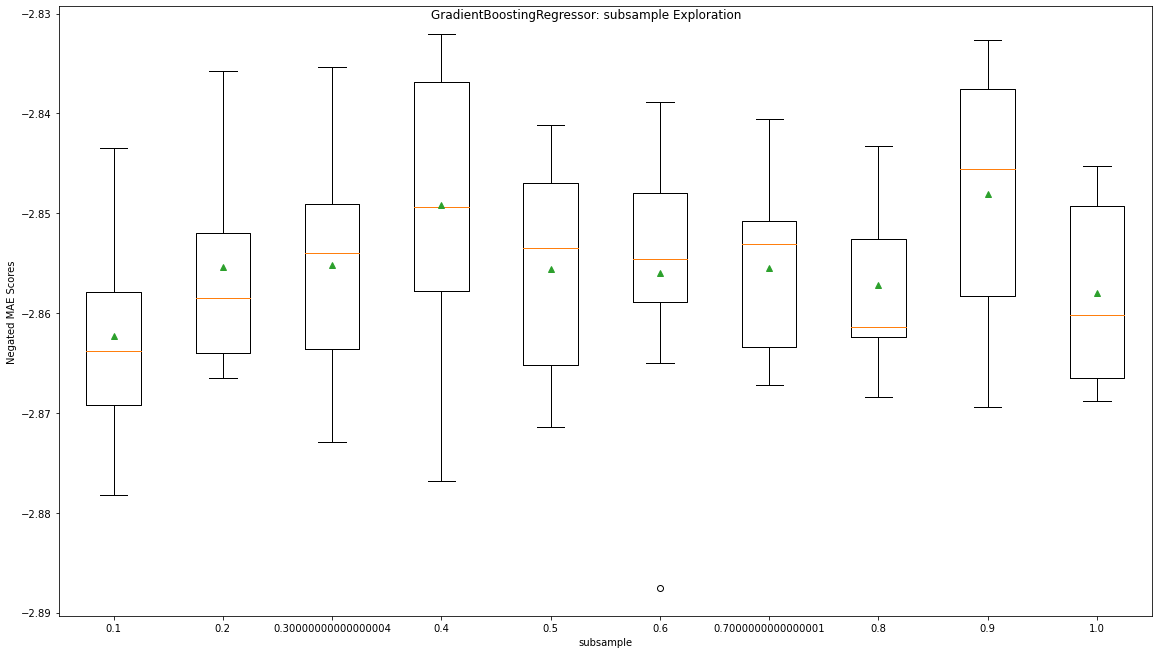

In [190]:
plot_param_plot('GradientBoostingRegressor: subsample Exploration', 'subsample', 'Negated MAE Scores', mae_reg_scores.values(), mae_reg_scores.keys(), 'gradientboost_10prct/run0/South-Holland_subsample_MAE.png')


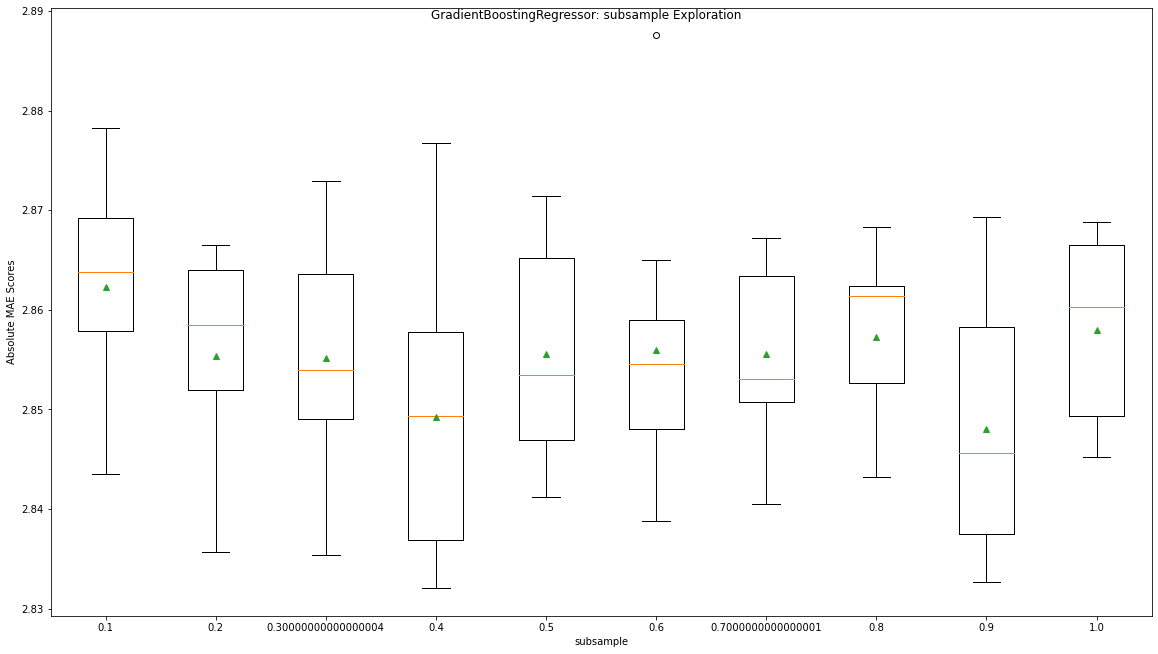

In [191]:
abs_mae_reg_scores = convert_abs_scores(mae_reg_scores)
plot_param_plot('GradientBoostingRegressor: subsample Exploration', 'subsample', 'Absolute MAE Scores', abs_mae_reg_scores.values(), abs_mae_reg_scores.keys(), 'gradientboost_10prct/run0/South-Holland_subsample_ABS-MAE.png')

In [192]:
max_depth_models = dict()
for i in range(1,11):
    max_depth_models[str(i)] = GradientBoostingRegressor(max_depth=i, random_state=model_seed)
# max_depth_models

In [193]:
mae_reg_scores, mse_reg_scores, r2_reg_scores = dict(), dict(), dict()
loop_evaluate_models('max_depth', max_depth_models)

max_depth 1
MAE -2.924 (0.014) | Elapsed time 1.130 seconds
max_depth 2
MAE -2.875 (0.008) | Elapsed time 1.127 seconds
max_depth 3
MAE -2.850 (0.010) | Elapsed time 1.096 seconds
max_depth 4
MAE -2.847 (0.008) | Elapsed time 1.082 seconds
max_depth 5
MAE -2.845 (0.006) | Elapsed time 1.067 seconds
max_depth 6
MAE -2.845 (0.010) | Elapsed time 1.097 seconds
max_depth 7
MAE -2.841 (0.012) | Elapsed time 1.060 seconds
max_depth 8
MAE -2.844 (0.009) | Elapsed time 1.069 seconds
max_depth 9
MAE -2.846 (0.009) | Elapsed time 1.054 seconds
max_depth 10
MAE -2.851 (0.009) | Elapsed time 1.067 seconds


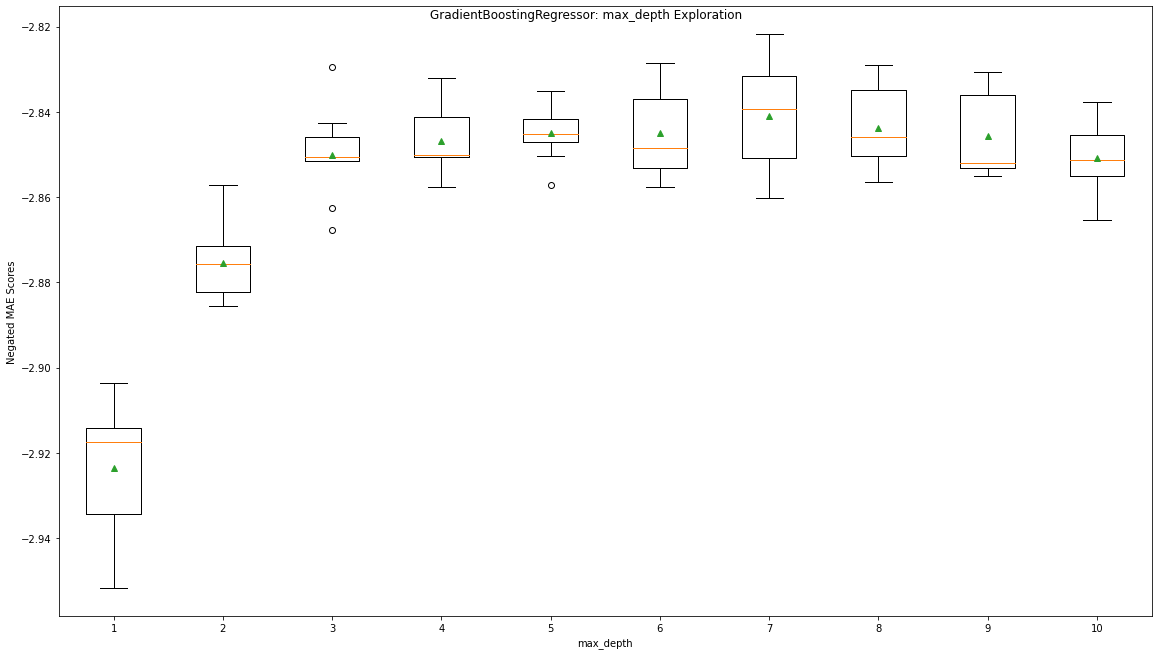

In [194]:
plot_param_plot('GradientBoostingRegressor: max_depth Exploration', 'max_depth', 'Negated MAE Scores', mae_reg_scores.values(), mae_reg_scores.keys(), 'gradientboost_10prct/run0/South-Holland_max_depth_MAE.png')


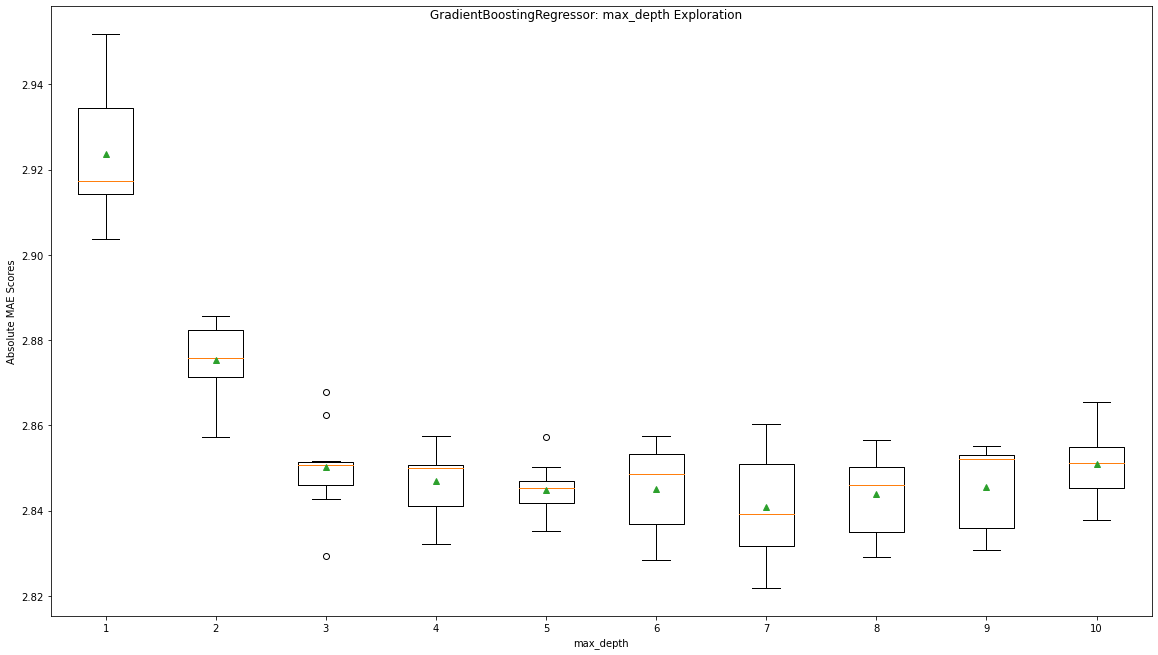

In [195]:
abs_mae_reg_scores = convert_abs_scores(mae_reg_scores)
plot_param_plot('GradientBoostingRegressor: max_depth Exploration', 'max_depth', 'Absolute MAE Scores', abs_mae_reg_scores.values(), abs_mae_reg_scores.keys(), 'gradientboost_10prct/run0/South-Holland_max_depth_ABS-MAE.png')

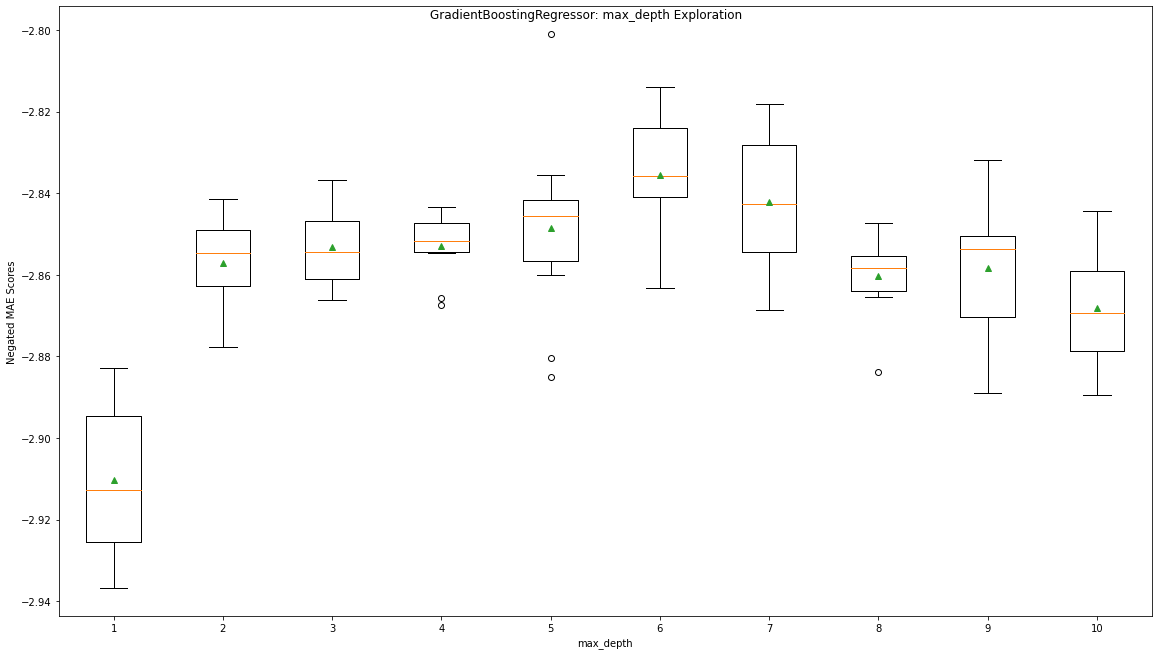

In [115]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('GradientBoostingRegressor: max_depth Exploration')
ax = fig.add_subplot (111)

plt.boxplot(mae_reg_scores.values(), showmeans=True)
ax.set_xticklabels(mae_reg_scores.keys())

plt.tight_layout()
plt.plot()
plt.xlabel('max_depth')
plt.ylabel('Negated MAE Scores')
plt.savefig('gradientboost_5prct/run0/South-Holland_max_depth_MAE.png', dpi=600)

In [116]:
abs_mae_reg_scores = {}
for k, v in mae_reg_scores.items():
    abs_mae_reg_scores[k] = np.absolute(v)

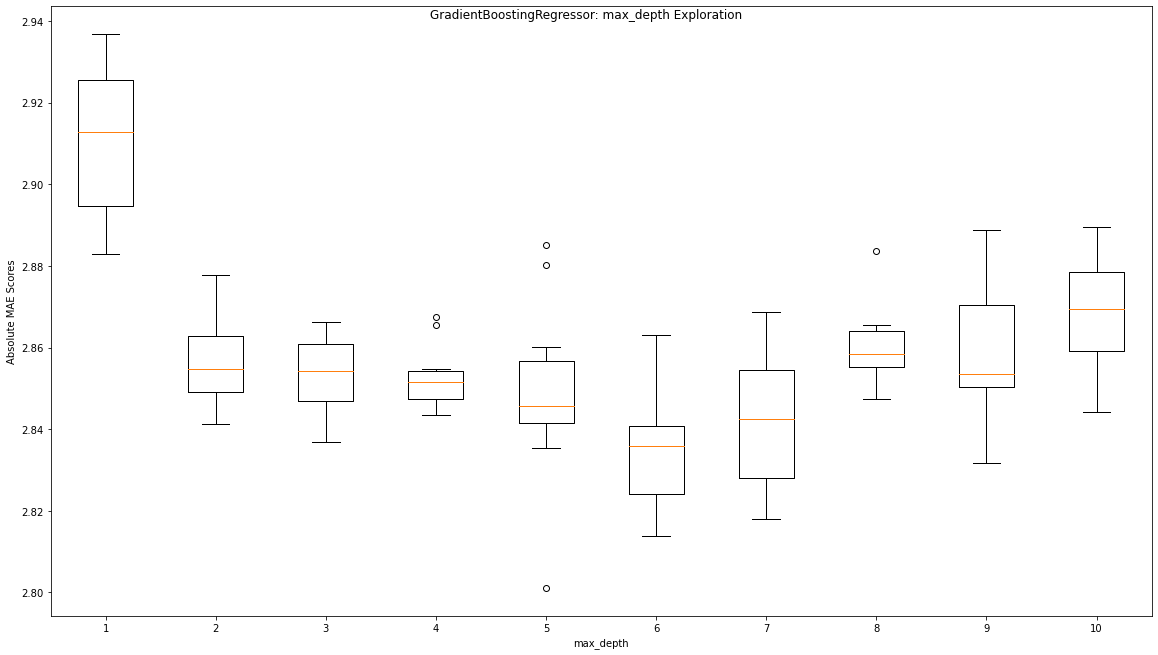

In [117]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('GradientBoostingRegressor: max_depth Exploration')
ax = fig.add_subplot (111)


plt.boxplot(abs_mae_reg_scores.values())
ax.set_xticklabels(abs_mae_reg_scores.keys())

plt.tight_layout()
plt.plot()
plt.xlabel('max_depth')
plt.ylabel('Absolute MAE Scores')
plt.savefig('gradientboost_5prct/run0/South-Holland_max_depth_ABS-MAE.png', dpi=600)

In [196]:
max_features_models = dict()
for i in np.arange(0.1, 1.1, 0.1):
    key = '%.1f' % i
    max_features_models[str(i)] = GradientBoostingRegressor(max_features=i, random_state=model_seed)
# max_features_models

In [197]:
mae_reg_scores, mse_reg_scores, r2_reg_scores = dict(), dict(), dict()
loop_evaluate_models('max_features', max_features_models)

max_features 0.1
MAE -2.916 (0.009) | Elapsed time 1.065 seconds
max_features 0.2
MAE -2.871 (0.006) | Elapsed time 1.065 seconds
max_features 0.30000000000000004
MAE -2.862 (0.012) | Elapsed time 1.005 seconds
max_features 0.4
MAE -2.857 (0.008) | Elapsed time 1.029 seconds
max_features 0.5
MAE -2.858 (0.012) | Elapsed time 1.011 seconds
max_features 0.6
MAE -2.854 (0.009) | Elapsed time 1.011 seconds
max_features 0.7000000000000001
MAE -2.853 (0.017) | Elapsed time 1.001 seconds
max_features 0.8
MAE -2.856 (0.009) | Elapsed time 1.010 seconds
max_features 0.9
MAE -2.858 (0.011) | Elapsed time 1.041 seconds
max_features 1.0
MAE -2.852 (0.009) | Elapsed time 1.022 seconds


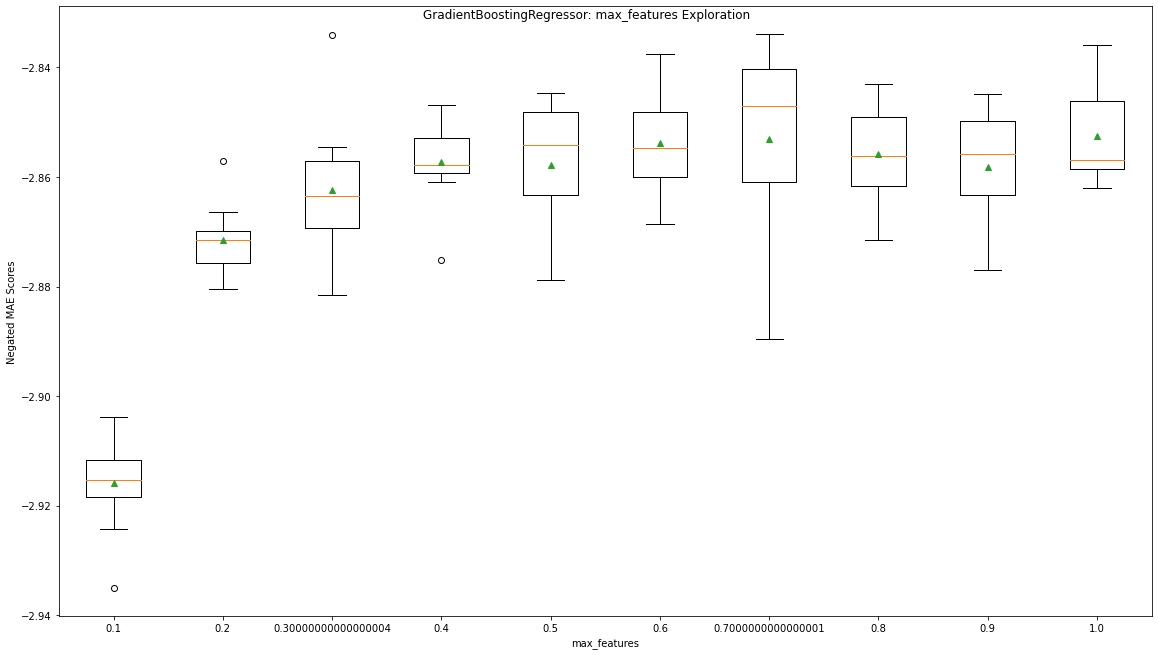

In [198]:
plot_param_plot('GradientBoostingRegressor: max_features Exploration', 'max_features', 'Negated MAE Scores', mae_reg_scores.values(), mae_reg_scores.keys(), 'gradientboost_10prct/run0/South-Holland_max_features_MAE.png')


In [ ]:
abs_mae_reg_scores = convert_abs_scores(mae_reg_scores)
plot_param_plot('GradientBoostingRegressor: max_features Exploration', 'max_features', 'Absolute MAE Scores', abs_mae_reg_scores.values(), abs_mae_reg_scores.keys(), 'gradientboost_10prct/run0/South-Holland_max_features_ABS-MAE.png')

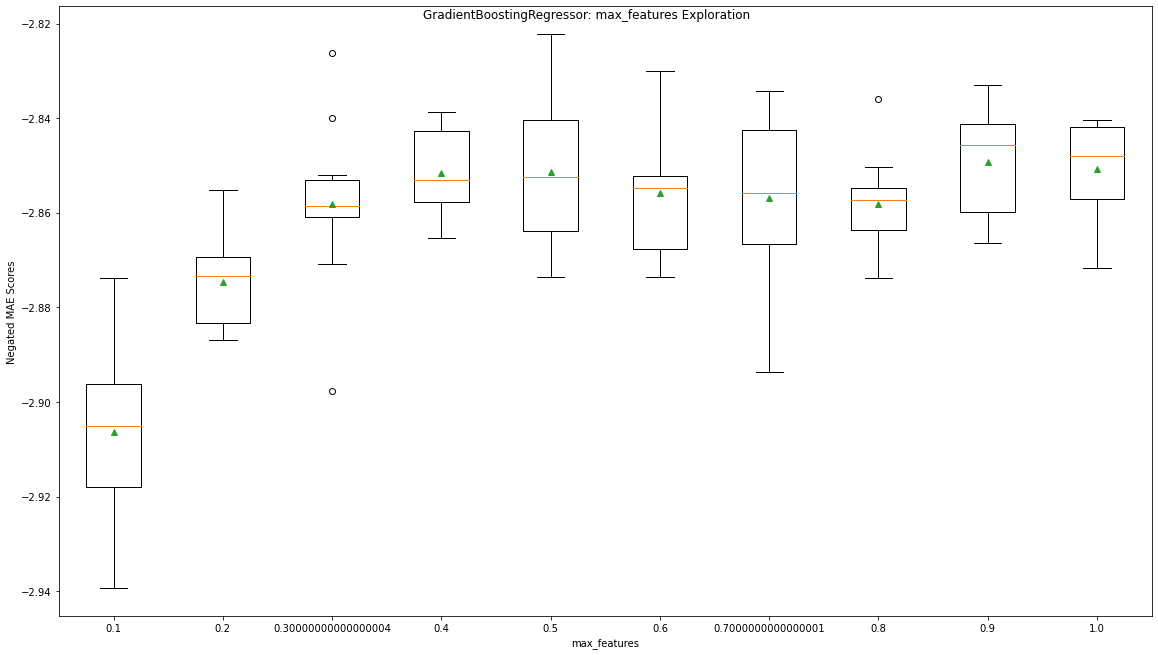

In [147]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('GradientBoostingRegressor: max_features Exploration')
ax = fig.add_subplot (111)

plt.boxplot(mae_reg_scores.values(), showmeans=True)
ax.set_xticklabels(mae_reg_scores.keys())

plt.tight_layout()
plt.plot()
plt.xlabel('max_features')
plt.ylabel('Negated MAE Scores')
plt.savefig('gradientboost_5prct/run0/South-Holland_max_features_MAE.png', dpi=600)

In [148]:
abs_mae_reg_scores = {}
for k, v in mae_reg_scores.items():
    abs_mae_reg_scores[k] = np.absolute(v)

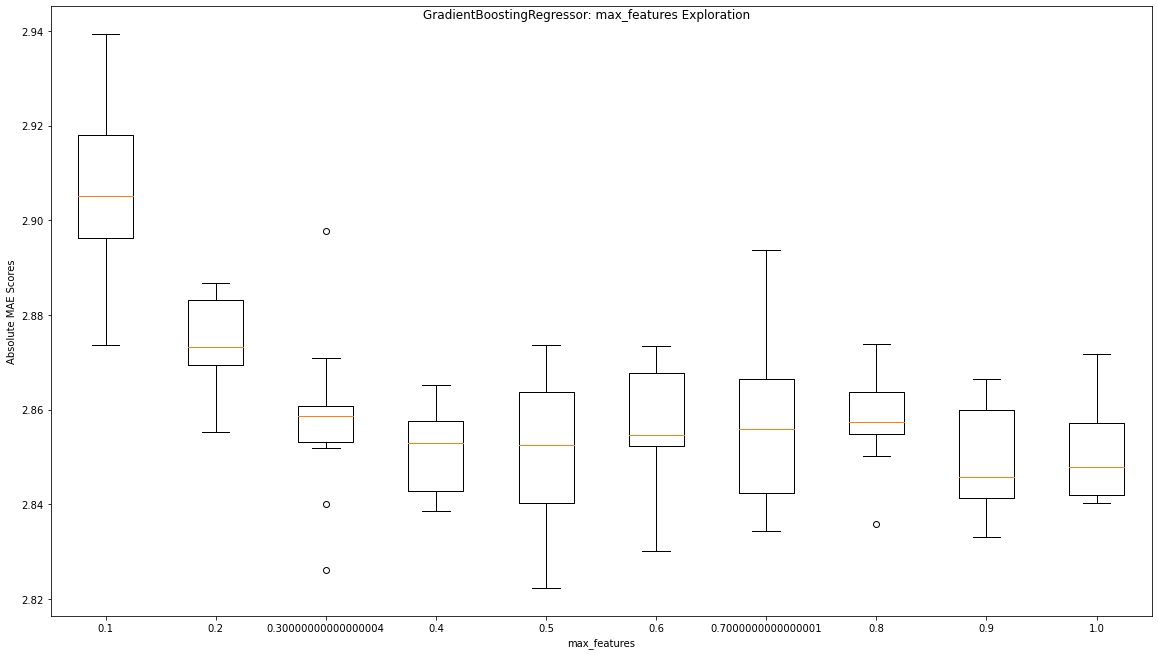

In [149]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('GradientBoostingRegressor: max_features Exploration')
ax = fig.add_subplot (111)


plt.boxplot(abs_mae_reg_scores.values())
ax.set_xticklabels(abs_mae_reg_scores.keys())

plt.tight_layout()
plt.plot()
plt.xlabel('max_features')
plt.ylabel('Absolute MAE Scores')
plt.savefig('gradientboost_5prct/run0/South-Holland_max_features_ABS-MAE.png', dpi=600)

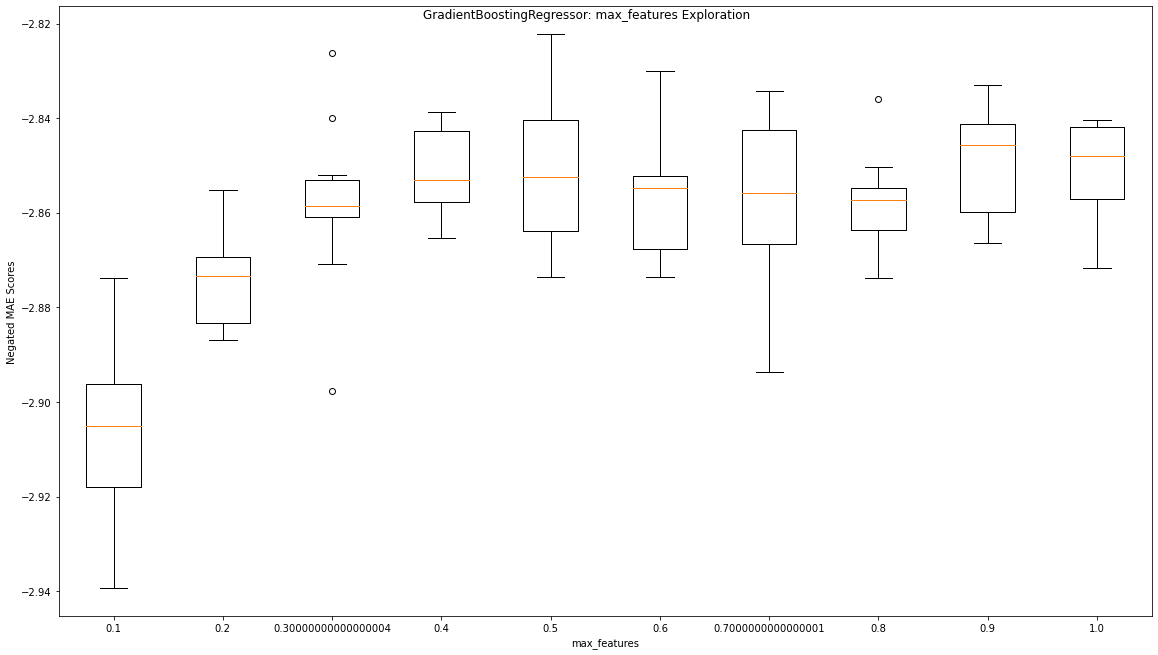

In [150]:
plot_param_plot('GradientBoostingRegressor: max_features Exploration', 'max_features', 'Negated MAE Scores', mae_reg_scores.values(), mae_reg_scores.keys(), 'gradientboost_5prct/run0/South-Holland_max_features_MAE.png')

In [ ]:
gs_pipeline_2 = Pipeline(steps=[('preprocessor', preprocessor_1), ('regressor', GradientBoostingRegressor(loss='ls'))])

In [ ]:
tic = time.process_time()
grid_search_2 = GridSearchCV(gs_pipeline_2, grid_params, cv=cv, n_jobs=-1)
grid_search_2.fit(X_train, y_train)
toc = time.process_time()
fit_time = toc - tic  
msg = "Gridsearch took %f seconds" % (fit_time)
print(msg)

In [ ]:
best_params_2 = grid_search_2.best_params_
best_params_2

In [ ]:
best_estimator_2 = grid_search_2.best_estimator_
best_estimator_2

In [ ]:
best_score_2 = grid_search_2.best_score_
best_score_2

In [ ]:
gs_pipeline_3 = Pipeline(steps=[('preprocessor', preprocessor_1), ('regressor', RandomForestRegressor(n_jobs=-1))])

In [ ]:
tic = time.process_time()
grid_search_3 = GridSearchCV(gs_pipeline_3, grid_params_1, cv=cv)
grid_search_3.fit(X_train, y_train)
toc = time.process_time()
fit_time = toc - tic  
msg = "Gridsearch took %f seconds" % (fit_time)
print(msg)

In [ ]:
best_params_3 = grid_search_3.best_params_
best_params_3

In [ ]:
best_estimator_3 = grid_search_3.best_estimator_
best_estimator_3

In [ ]:
best_score_3 = grid_search_3.best_score_
best_score_3